In [1]:
#Imports
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from pathlib import Path
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils import shuffle
import math

In [2]:
def data_import(npz_file_path="simulation_results_all.npz", train_split=0.9):
    """
    Import and prepare data from the .npz simulation results file.
    
    DATASET USAGE EXPLANATION:
    - Total dataset: ~10,000 simulation results
    - train_split=0.5 means 50% for training, 50% for testing
    - Training data: ~5,000 samples (used to learn network weights)
    - Test data: ~5,000 samples (used to evaluate performance, NEVER seen during training)
    
    Parameters:
    npz_file_path (str): Path to the .npz file containing simulation results
    train_split (float): Fraction of data to use for training (default: 0.5 = 50%)
    
    Returns:
    tuple: (x_train, y_train, x_test, y_test, s_force, normalization_params)
           - x_train: Training inputs (24 features × n_train_samples)
           - y_train: Training targets (600 force values × n_train_samples)
           - x_test: Test inputs (24 features × n_test_samples)
           - y_test: Test targets (600 force values × n_test_samples)
           - s_force: Arc length positions for force profiles
           - normalization_params: Statistics for denormalizing predictions
    """
    print(f"Loading data from {npz_file_path}...")
    
    
    # Load the data
    npz_data = np.load('simulation_results_all_11-23.npz', allow_pickle=True)
    simulation_results = npz_data['data']
    
    print(f"Total number of simulations: {len(simulation_results)}")
    
    # Extract features and targets
    input_features = []
    output_forces = []
    
    for sim in simulation_results:
        # Input: All actuator data for segments 1-4 (24 features total)
        # L1_input, L1_def, L2_input, L2_def, L3_input, L3_def for each segment
        inputs = [
            sim['L1_input_1'], sim['L1_def_1']-sim['L1_input_1'], sim['L2_input_1'], sim['L2_def_1']-sim['L2_input_1'], sim['L3_input_1'], sim['L3_def_1']-sim['L3_input_1'],
            sim['L1_input_2'], sim['L1_def_2']-sim['L1_input_2'], sim['L2_input_2'], sim['L2_def_2']-sim['L2_input_2'], sim['L3_input_2'], sim['L3_def_2']-sim['L3_input_2'],
            sim['L1_input_3'], sim['L1_def_3']-sim['L1_input_3'], sim['L2_input_3'], sim['L2_def_3']-sim['L2_input_3'], sim['L3_input_3'], sim['L3_def_3']-sim['L3_input_3'],
            sim['L1_input_4'], sim['L1_def_4']-sim['L1_input_4'], sim['L2_input_4'], sim['L2_def_4']-sim['L2_input_4'], sim['L3_input_4'], sim['L3_def_4']-sim['L3_input_4']
        ]
        
        # Output: Concatenated force distributions (600 values total)
        forces = np.concatenate([
            sim['f_dist_fx'],  # 200 values - Force X
            sim['f_dist_fy'],  # 200 values - Force Y
            sim['f_dist_fz']   # 200 values - Force Z
        ])
        
        input_features.append(inputs)
        output_forces.append(forces)
    
    X = np.array(input_features)  # Shape: (n_samples, 24)
    Y = np.array(output_forces)   # Shape: (n_samples, 600)
    
    # Create mask where every feature is between 2 and 10
    mask = np.all((X >= -10) & (X <= 10), axis=1)
    print("Original size:", X.shape)
    # Filter
    X = X[mask]
    Y = Y[mask]

    print("Original size:", Y.shape)
    print("Filtered size:", X.shape)

    
    return X, Y

In [3]:
X, Y = data_import()



Loading data from simulation_results_all.npz...
Total number of simulations: 100000
Original size: (100000, 24)
Original size: (99987, 288)
Filtered size: (99987, 24)


In [ ]:


# ---------- Whitening helper (same idea as earlier) ----------
def compute_whitening(Y, eps=1e-8):
    Y_mean = np.mean(Y, axis=0, keepdims=True)
    Y_centered = Y - Y_mean
    cov = np.cov(Y_centered, rowvar=False)
    U, S, Vt = np.linalg.svd(cov, full_matrices=True)
    V = Vt.T
    S = np.maximum(S, 0.0)
    def whiten(Y_in):
        Yc = Y_in - Y_mean
        return (Yc @ (V @ np.diag(1.0 / np.sqrt(S + eps))))
    def unwhiten(Y_white):
        return (Y_white @ (np.diag(np.sqrt(S + eps)) @ V.T)) + Y_mean
    return {"mean": Y_mean, "V": V, "S": S, "eps": eps, "whiten_fn": whiten, "unwhiten_fn": unwhiten}

# ---------- Positional Encoding (sinusoidal) ----------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x is (seq_len, batch, d_model)
        seq_len = x.size(0)
        return x + self.pe[:seq_len]

# ---------- Transformer model: encoder (sensor tokens) -> decoder (output positions) ----------
class Sensor2FieldTransformer(nn.Module):
    def __init__(
        self,
        input_token_dim=3,   # per-sensor features: before, after, diff
        src_len=12,          # number of sensor tokens
        tgt_len=96,          # number of output positions
        tgt_chan=3,          # channels per output position (Fx,Fy,Fz)
        d_model=256,
        nhead=8,
        num_encoder_layers=4,
        num_decoder_layers=4,
        dim_feedforward=512,
        dropout=0.1,
    ):
        super().__init__()
        self.src_len = src_len
        self.tgt_len = tgt_len
        self.tgt_chan = tgt_chan
        self.d_model = d_model

        # input token embedding (linear -> d_model)
        self.src_embed = nn.Linear(input_token_dim, d_model)
        self.src_pos = PositionalEncoding(d_model, max_len=src_len+10)

        # target token embedding: project 3-channel target to d_model (used during training)
        self.tgt_embed = nn.Linear(tgt_chan, d_model)
        self.tgt_pos = PositionalEncoding(d_model, max_len=tgt_len+10)

        # transformer
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False,  # we'll pass seq_len, batch, d_model
        )

        # output projection (from decoder outputs for each position to channels)
        self.output_proj = nn.Linear(d_model, tgt_chan)

        # Init
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, src_tokens, tgt_tokens, src_key_padding_mask=None, tgt_key_padding_mask=None):
        """
        src_tokens: (batch, src_len, input_token_dim)
        tgt_tokens: (batch, tgt_len, tgt_chan)  -> during training this is the true target in whitened space
        Returns: preds (batch, tgt_len, tgt_chan)
        """
        # transpose to (seq_len, batch, dim) for nn.Transformer
        src = self.src_embed(src_tokens)          # (B, src_len, d_model)
        src = src.permute(1, 0, 2)               # (src_len, B, d_model)
        src = self.src_pos(src)

        tgt = self.tgt_embed(tgt_tokens)         # (B, tgt_len, d_model)
        tgt = tgt.permute(1, 0, 2)               # (tgt_len, B, d_model)
        tgt = self.tgt_pos(tgt)

        memory = self.transformer.encoder(src, src_key_padding_mask=src_key_padding_mask)
        out = self.transformer.decoder(tgt, memory, tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=src_key_padding_mask)

        # out: (tgt_len, B, d_model) -> project to channels
        out = out.permute(1, 0, 2)  # (B, tgt_len, d_model)
        out = self.output_proj(out) # (B, tgt_len, tgt_chan)
        return out  # (B, tgt_len, tgt_chan)

    def infer(self, src_tokens, device=None):
        """
        Simple non-autoregressive inference by feeding zeros as decoder input.
        src_tokens: (batch, src_len, input_token_dim)
        returns: preds (batch, tgt_len, tgt_chan)
        """
        B = src_tokens.shape[0]
        zeros = torch.zeros(B, self.tgt_len, self.tgt_chan, device=src_tokens.device)
        self.eval()
        with torch.no_grad():
            preds = self.forward(src_tokens, zeros)
        return preds

# ---------- Training function ----------
def train_transformer(
    X, Y,
    batch_size=256,
    epochs=60,
    lr=3e-4,
    weight_decay=1e-6,
    d_model=256,
    nhead=8,
    enc_layers=4,
    dec_layers=4,
    ff_dim=512,
    dropout=0.1,
    val_fraction=0.08,
    patience=8,
    grad_lambda=0.05,
    whiten_outputs=True,
    device=None,
    seed=42,
    verbose=True
):
    """
    Train a transformer seq2seq model mapping sensor tokens -> distributed force tokens.
    Inputs:
      - X: (N, 24) numpy array (12 sensors * [before, after])
      - Y: (N, 288) numpy array (96 positions * 3 channels)
    Returns:
      results dict containing model, scalers, losses, and example predictions (unwhitened)
    """

    torch.manual_seed(seed)
    np.random.seed(seed)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N, D = X.shape
    assert D == 24, "X must be shape (N,24)"
    assert Y.shape[0] == N and Y.shape[1] == 288, "Y must be shape (N,288)"

    # ---------- Per-sensor feature engineering and normalization ----------
    # Build features per sensor: before, after, diff
    X_feats = np.zeros((N, 12, 3), dtype=np.float32)  # (N, sensors, features)
    sensor_means = []
    sensor_stds = []
    for s in range(12):
        before = X[:, 2*s].astype(np.float32)
        after  = X[:, 2*s + 1].astype(np.float32)
        diff = after - before
        block = np.stack([before, after, diff], axis=1)  # (N,3)
        mean = block.mean(axis=0, keepdims=True)
        std  = block.std(axis=0, keepdims=True) + 1e-8
        block_norm = (block - mean) / std
        X_feats[:, s, :] = block_norm
        sensor_means.append(mean.flatten())
        sensor_stds.append(std.flatten())
    sensor_means = np.stack(sensor_means, axis=0)  # (12,3)
    sensor_stds = np.stack(sensor_stds, axis=0)    # (12,3)

    # Flatten sensor tokens for dataset input shape (N, src_len, token_dim)
    src_tokens = X_feats  # (N, 12, 3)

    # ---------- Output whitening (optional) ----------
    if whiten_outputs:
        whiten = compute_whitening(Y, eps=1e-8)
        Y_white = whiten["whiten_fn"](Y).astype(np.float32)  # (N, 288)
    else:
        whiten = None
        Y_white = Y.astype(np.float32)

    # reshape Y to (N, tgt_len=96, 3)
    Y_tokens = Y_white.reshape(N, 96, 3)  # (N,96,3)

    # ---------- Dataset / loaders ----------
    src_sh, tgt_sh = shuffle(src_tokens, Y_tokens, random_state=seed)
    dataset = TensorDataset(torch.from_numpy(src_sh).float(), torch.from_numpy(tgt_sh).float())
    val_size = int(len(dataset) * val_fraction)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True)

    # ---------- Model ----------
    model = Sensor2FieldTransformer(
        input_token_dim=3,
        src_len=12,
        tgt_len=96,
        tgt_chan=3,
        d_model=d_model,
        nhead=nhead,
        num_encoder_layers=enc_layers,
        num_decoder_layers=dec_layers,
        dim_feedforward=ff_dim,
        dropout=dropout
    ).to(device)

    # criterion and optimizer
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # gradient loss (finite differences along length) in whitened space is OK because transform is linear
    def gradient_loss(pred, target):
        # pred, target: (B, 96, 3)
        dp = pred[:, 1:, :] - pred[:, :-1, :]
        dt = target[:, 1:, :] - target[:, :-1, :]
        return torch.mean((dp - dt) ** 2)

    # training bookkeeping
    train_losses = []
    val_losses = []
    best_val = float('inf')
    patience_ctr = 0
    best_state = None

    example_src = None
    example_tgt_unwhiten = None
    example_pred_unwhiten = None

    # ---------- Training loop ----------
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)           # (B, 12, 3)
            yb = yb.to(device)           # (B, 96, 3)  (whitened or raw depending)
            optimizer.zero_grad()
            # Forward: provide full ground-truth tgt tokens (non-autoregressive teacher forcing)
            preds = model(xb, yb)        # (B, 96, 3)
            loss_point = criterion(preds, yb)
            loss_grad = gradient_loss(preds, yb)
            loss = loss_point + grad_lambda * loss_grad
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)

        train_epoch_loss = running_loss / train_size
        train_losses.append(train_epoch_loss)

        # Validate
        model.eval()
        val_running = 0.0
        last_preds = None
        last_tgts = None
        last_srcs = None
        with torch.no_grad():
            for i, (xb, yb) in enumerate(val_loader):
                xb = xb.to(device)
                yb = yb.to(device)
                preds = model(xb, yb)  # teacher forcing during validation as well
                loss_point = criterion(preds, yb)
                loss_grad = gradient_loss(preds, yb)
                loss = loss_point + grad_lambda * loss_grad
                val_running += loss.item() * xb.size(0)

                last_preds = preds.cpu().numpy()
                last_tgts  = yb.cpu().numpy()
                last_srcs  = xb.cpu().numpy()

        val_epoch_loss = val_running / val_size
        val_losses.append(val_epoch_loss)

        if verbose:
            print(f"Epoch {epoch:02d}/{epochs} | Train: {train_epoch_loss:.6e} | Val: {val_epoch_loss:.6e} | LR: {scheduler.get_last_lr()[0]:.2e}")

        scheduler.step()

        # early stopping save
        if val_epoch_loss < best_val - 1e-12:
            best_val = val_epoch_loss
            patience_ctr = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch} (best val {best_val:.6e})")
                break

        # store last batch for plotting
        example_src = last_srcs
        example_tgt_white = last_tgts
        example_pred_white = last_preds

    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)

    # Inverse transform example preds/targets to original physical space (unwhiten)
    if whiten is not None and example_pred_white is not None:
        # example arrays are shape (B, 96, 3) in whitened space; reshape to (B, 288) -> unwhiten -> reshape
        B_ = example_pred_white.shape[0]
        preds_flat = example_pred_white.reshape(B_, -1)
        tgts_flat  = example_tgt_white.reshape(B_, -1)
        preds_un = whiten["unwhiten_fn"](preds_flat)  # (B,288)
        tgts_un  = whiten["unwhiten_fn"](tgts_flat)
        example_pred_unwhiten = preds_un
        example_tgt_unwhiten  = tgts_un
    else:
        if example_pred_white is not None:
            example_pred_unwhiten = example_pred_white.reshape(example_pred_white.shape[0], -1)
            example_tgt_unwhiten  = example_tgt_white.reshape(example_tgt_white.shape[0], -1)

    # package scalers
    scalers = {
        "sensor_means": sensor_means,   # (12,3)
        "sensor_stds": sensor_stds,
        "whiten": whiten
    }

    results = (
        model,
        np.array(train_losses),
        np.array(val_losses),
        example_src,    # normalized per-sensor features (N_batch, 12, 3)
        example_tgt_unwhiten, # (B, 288) or None
        example_pred_unwhiten, # (B, 288) or None
  
    )

    return results

# ---------- Simple inference helper (non-autoregressive) ----------
def transformer_predict(model, X_raw, scalers, device=None, whiten_outputs=True):
    """
    X_raw: (N,24) raw sensor data (before, after)
    scalers: dict containing sensor_means, sensor_stds, whiten
    returns predictions in original (unwhitened) space shape (N,288)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()

    # build normalized features
    N = X_raw.shape[0]
    X_feats = np.zeros((N, 12, 3), dtype=np.float32)
    for s in range(12):
        before = X_raw[:, 2*s].astype(np.float32)
        after  = X_raw[:, 2*s+1].astype(np.float32)
        diff = after - before
        mean = scalers["sensor_means"][s].reshape(1,3)
        std  = scalers["sensor_stds"][s].reshape(1,3)
        block = np.stack([before, after, diff], axis=1)
        block_norm = (block - mean) / (std + 1e-12)
        X_feats[:, s, :] = block_norm

    src_tokens = torch.from_numpy(X_feats).float().to(device)
    with torch.no_grad():
        preds = model.infer(src_tokens)  # (B, 96, 3)
    preds_np = preds.cpu().numpy().reshape(N, -1)  # (N,288)

    if whiten_outputs and scalers.get("whiten") is not None:
        preds_un = scalers["whiten"]["unwhiten_fn"](preds_np)
        return preds_un
    else:
        return preds_np

In [5]:
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
def plot_force_prediction_vs_actual(y_true, y_pred, segment_labels=None):
    """
    y_true, y_pred: numpy arrays shape (288,) = 96 sections × 3 directions (X,Y,Z)
    segment_labels: optional list of length 96 for x-axis labels (e.g., section numbers)
    """


    sections = 96
    directions = ['Fx', 'Fy', 'Fz']
    
    # Reshape to (3, 96)
    y_true = y_true.reshape(3, sections)
    y_pred = y_pred.reshape(3, sections)
    
    x_axis = segment_labels if segment_labels is not None else np.arange(1, sections+1)
    
    plt.figure(figsize=(12,8))
    for i, direction in enumerate(directions):
        plt.subplot(3, 1, i+1)
        plt.plot(x_axis, y_true[i], label='Actual', marker='o')
        plt.plot(x_axis, y_pred[i], label='Predicted', marker='x')
        plt.ylabel(f'Force {direction}')
        plt.grid(True)
        if i == 0:
            plt.title('Force Distribution: Actual vs Predicted')
        if i == 2:
            plt.xlabel('Section')
        plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
model, train_losses, val_losses, X_example, y_true_example, y_pred_example = train_transformer(X, Y,
    batch_size=256,
    epochs=3,
    lr=3e-4,
    weight_decay=1e-6,
    d_model=256,
    nhead=8,
    enc_layers=4,
    dec_layers=4,
    ff_dim=512,
    dropout=0.1,
    val_fraction=0.08,
    patience=10,
    grad_lambda=0.05,
    whiten_outputs=True,
    verbose=True
)

Epoch 01/3 | Train: 1.820035e-01 | Val: 1.387711e-03 | LR: 3.00e-04
Epoch 02/3 | Train: 1.132189e-02 | Val: 1.205700e-03 | LR: 2.25e-04
Epoch 03/3 | Train: 7.467856e-03 | Val: 1.054288e-03 | LR: 7.50e-05


In [19]:
model, train_losses, val_losses, X_example, y_true_example, y_pred_example = train_force_estimator_cnn(
    X, Y,
    batch_size=256,
    epochs=100,
    learning_rate=.5e-3,
    weight_decay=1e-7,
    val_fraction=0.1,
    patience=100,
    verbose=True
)

#.80

Epoch 01 — Train Loss: 0.960759  Val Loss: 0.947431


KeyboardInterrupt: 

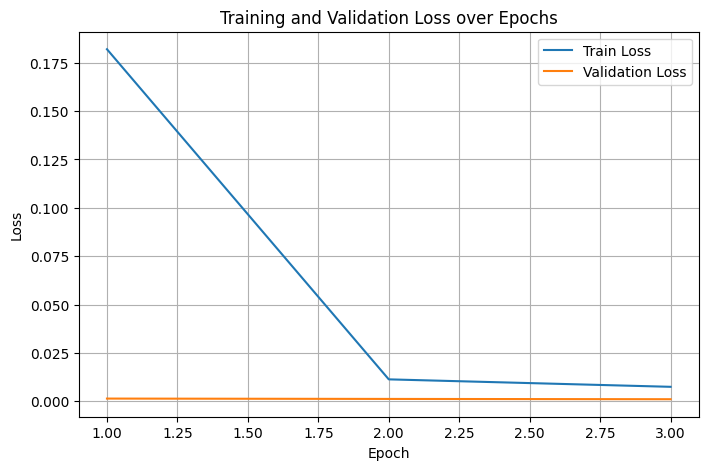

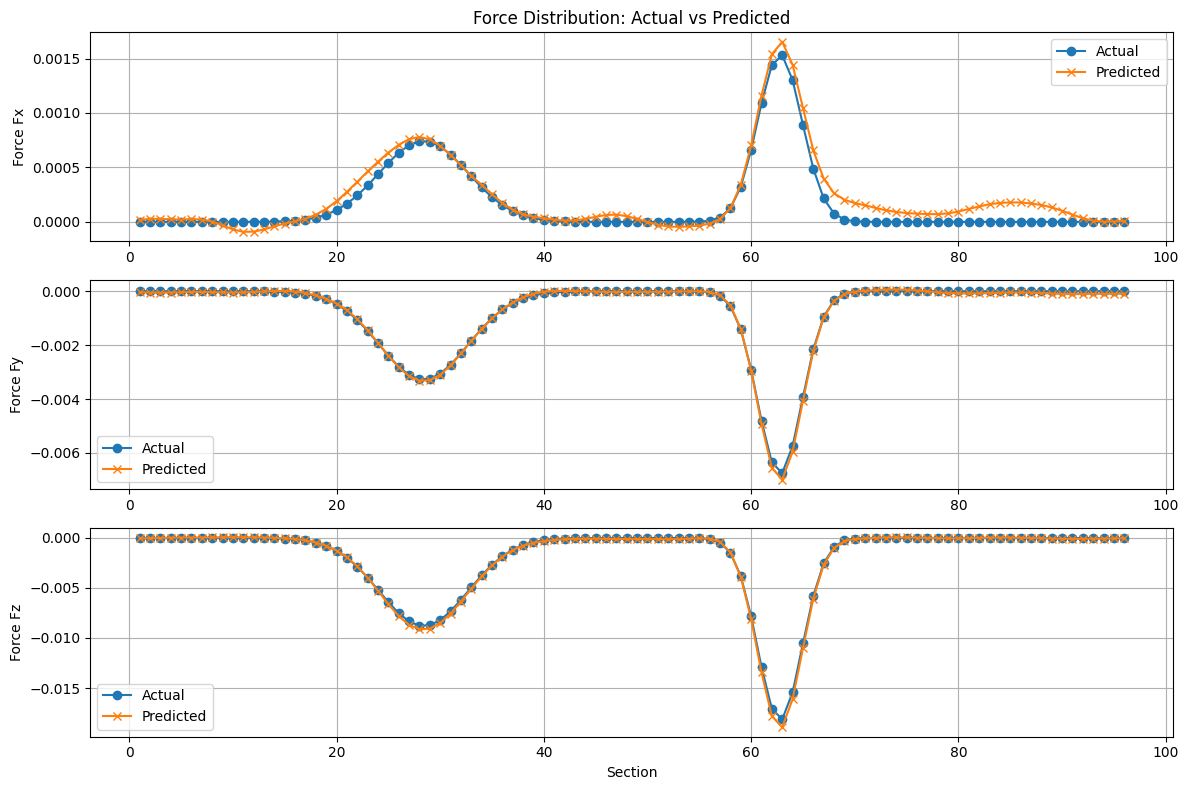

In [20]:
plot_losses(train_losses, val_losses)
random_integer = np.random.randint(0, 12)
plot_force_prediction_vs_actual(y_true_example[random_integer], y_pred_example[random_integer])
